<img src="img/dsci572_header.png" width="600">

# Lab 4: Transfer Learning and GANs

## Instructions
<hr>

rubric={mechanics:5}

- Follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/)

- Upload a PDF version of your lab notebook to Gradescope, in addition to the .ipynb file.

- Add a link to your GitHub repository here: https://github.ubc.ca/MDS-2022-23/DSCI_572_lab4_mengjun5

## Imports
<hr>

In [31]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from statistics import mean


plt.rcParams.update({'axes.grid': False})

## Getting Started with Kaggle
<hr>

We are going to run this notebook on the cloud using [Kaggle](https://www.kaggle.com). Kaggle offers 30 hours of free GPU usage per week which should be much more than enough for this lab. To get started, follow these steps:

1. Go to https://www.kaggle.com/kernels

2. Make an account if you don't have one, and verify your phone number (to get access to GPUs)
3. Select `+ New Notebook`
4. Go to `File -> Import Notebook`
5. Upload this notebook
6. On the right-hand side of your Kaggle notebook, make sure:
  
  - `Internet` is enabled.
  
  - In the `Accelerator` dropdown, choose one of the GPU options when you're ready to use it (you can turn it on/off as you need it).
    
Once you've done all your work on Kaggle, you can download the notebook from Kaggle. That way any work you did on Kaggle won't be lost.

## Exercise 1: Transfer Learning
<hr>

rubric={accuracy:15}

In this exercise you're going to practice transfer learning. We're going to develop a model that can detect the following 6 cat breeds in this Kaggle [dataset](https://www.kaggle.com/solothok/cat-breed):

1. American Short hair

2. Bengal
3. Maine Soon
4. Ragdoll
5. Scottish Fold
6. Sphinx

In order to use this dataset 

1. Click `+ Add data` at the top right of the notebook.

2. Search for **"cat-breed"** and click `Add`

### 1.1: CNN from Scratch

In this exercise, you should build a CNN model to classify images of cats based on their breeds.

In Kaggle, running the follow cell should print out `"Using device: cuda"` which means a GPU is available:

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cpu


To make use of the GPU, you should:
1. Move your model to the GPU after creating it using this syntax:

```python
model.to(device)
```

2. In your training/validation loops, each batch should be moved to the GPU using syntax like:

```python
for X, y in dataloader:
    X, y = X.to(device), y.to(device)
    ...
```

Here are some guidelines for building your binary classification CNN from scratch:

- You may use any architecture you like.

- This is the path to the data in your notebook: `../input/cat-breed/cat-breed/`
- You should use an `IMAGE_SIZE = 200` pixels in your data loader (the raw images could be any size).
- **You must train your model for at least 20 epochs and print or plot the accuracy for each epoch on the validation data for us to see.**

>If you want to take a look at the images after making a `train_loader`, try this code:

```python
# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));
```

In [15]:
#data load train
TRAIN_DIR = '../input/cat-breed/cat-breed/TRAIN'
train_dataset = datasets.ImageFolder(root=TRAIN_DIR)
#data load test
TEST_DIR = '../input/cat-breed/cat-breed/TEST'
test_dataset = datasets.ImageFolder(root=TEST_DIR)

In [17]:
IMAGE_SIZE = (200, 200)

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])
# load data with size 200
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=data_transforms)

In [19]:
BATCH_SIZE = 256
#data loader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

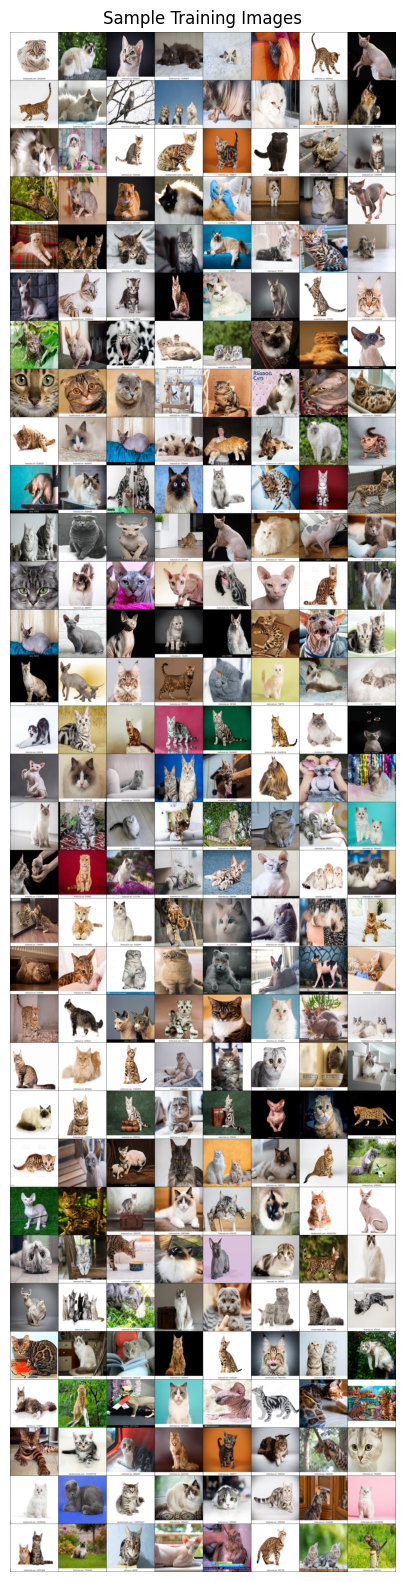

In [21]:
# Plot samples
sample_batch = next(iter(trainloader))
plt.figure(figsize=(20, 20)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

In [18]:
#Create CNN 
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, (5, 5)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),

            nn.Conv2d(32, 16, (5, 5)),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 8, (3, 3)),
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.Conv2d(8, 4, (3, 3)),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            
            
            nn.Flatten(),
            nn.Linear(7396, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [20]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=20, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type in ['cuda', 'mps']:
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            y_hat_labels = torch.argmax(y_hat.detach(), dim = 1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type in ['cuda', 'mps']:
                    X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y_hat_labels = torch.argmax(y_hat.detach(), dim = 1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels == y).type(torch.float32).mean().item()
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}

In [ ]:
model = CNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = optim.Adam(model.parameters(), lr=2e-4)
results = trainer(model, criterion, optimizer, trainloader, validloader, device, epochs=20)

1. Epoch 1: Train Accuracy: 0.27 Valid Accuracy: 0.16
2. Epoch 2: Train Accuracy: 0.44 Valid Accuracy: 0.20
3. Epoch 3: Train Accuracy: 0.54 Valid Accuracy: 0.19
4. Epoch 4: Train Accuracy: 0.56 Valid Accuracy: 0.17
5. Epoch 5: Train Accuracy: 0.61 Valid Accuracy: 0.16
6. Epoch 6: Train Accuracy: 0.65 Valid Accuracy: 0.21
7. Epoch 7: Train Accuracy: 0.69 Valid Accuracy: 0.20
8. Epoch 8: Train Accuracy: 0.71 Valid Accuracy: 0.27
9. Epoch 9: Train Accuracy: 0.76 Valid Accuracy: 0.18
10. Epoch 10: Train Accuracy: 0.80 Valid Accuracy: 0.29
11. Epoch 11: Train Accuracy: 0.83 Valid Accuracy: 0.33
12. Epoch 12: Train Accuracy: 0.87 Valid Accuracy: 0.42
13. Epoch 13: Train Accuracy: 0.91 Valid Accuracy: 0.48
14. Epoch 14: Train Accuracy: 0.93 Valid Accuracy: 0.51
15. Epoch 15: Train Accuracy: 0.95 Valid Accuracy: 0.52
16. Epoch 16: Train Accuracy: 0.96 Valid Accuracy: 0.56
17. Epoch 17: Train Accuracy: 0.97 Valid Accuracy: 0.55
18. Epoch 18: Train Accuracy: 0.99 Valid Accuracy: 0.59
19. Epoch 19: Train Accuracy: 0.99 Valid Accuracy: 0.57
20. Epoch 20: Train Accuracy: 0.99 Valid Accuracy: 0.54

### 1.2: Feature Extractor

In this exercise, you should leverage a pre-trained model customized with your own layer(s) on top, to build a CNN classifier that can identify various cat breeds.

- You can use any model you wish. I used `DenseNet`.

- Train your model for at least 20 epochs.

- Comment on the performance of this model compared to your "from scratch" model.

the performance is much better than my scratch model

In [ ]:
densenet = models.densenet121(pretrained=True)
for param in densenet.parameters():  # Freeze parameters so we don't update them
    param.requires_grad = False

In [ ]:
densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, trainloader, validloader, device, epochs=20)

1. Epoch 1: Train Accuracy: 0.57 Valid Accuracy: 0.46
2. Epoch 2: Train Accuracy: 0.80 Valid Accuracy: 0.81
3. Epoch 3: Train Accuracy: 0.90 Valid Accuracy: 0.89
4. Epoch 4: Train Accuracy: 0.93 Valid Accuracy: 0.94
5. Epoch 5: Train Accuracy: 0.95 Valid Accuracy: 0.87
6. Epoch 6: Train Accuracy: 0.96 Valid Accuracy: 0.90
7. Epoch 7: Train Accuracy: 0.96 Valid Accuracy: 0.86
8. Epoch 8: Train Accuracy: 0.97 Valid Accuracy: 0.91
9. Epoch 9: Train Accuracy: 0.97 Valid Accuracy: 0.92
10. Epoch 10: Train Accuracy: 0.98 Valid Accuracy: 0.90
11. Epoch 11: Train Accuracy: 0.99 Valid Accuracy: 0.95
12. Epoch 12: Train Accuracy: 0.99 Valid Accuracy: 0.91
13. Epoch 13: Train Accuracy: 0.99 Valid Accuracy: 0.91
14. Epoch 14: Train Accuracy: 0.99 Valid Accuracy: 0.89
15. Epoch 15: Train Accuracy: 1.00 Valid Accuracy: 0.90
16. Epoch 16: Train Accuracy: 1.00 Valid Accuracy: 0.92
17. Epoch 17: Train Accuracy: 0.99 Valid Accuracy: 0.93
18. Epoch 18: Train Accuracy: 0.99 Valid Accuracy: 0.90
19. Epoch 19: Train Accuracy: 1.00 Valid Accuracy: 0.92
10. Epoch 20: Train Accuracy: 1.00 Valid Accuracy: 0.93

### 1.3: Fine Tuning

In this final exercise, you should fine-tune your model by updating all or some of the layers during training.

- You can fine-tune as many layers as you like: the whole model, or particular layers. Experiment with both modes of fine-tuning, and find which works better.

- Train your model for at least 20 epochs.

- Comment on the performance of this model compared to your "from scratch" and "feature extractor" models.

The overall performance is much better than scratch and slightly better tahn feature extractor.

In [ ]:
new_layers = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 6)
)
densenet.classifier = new_layers
# Freeze all but the last three layers
for layer in densenet.features[:-3]:
    for param in layer.parameters():
        param.requires_grad = False

In [ ]:
densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=2e-3)
results = trainer(densenet, criterion, optimizer, trainloader, validloader, device, epochs=20)

1. Epoch 1: Train Accuracy: 0.86 Valid Accuracy: 0.70
2. Epoch 2: Train Accuracy: 0.92 Valid Accuracy: 0.91
3. Epoch 3: Train Accuracy: 0.93 Valid Accuracy: 0.86
4. Epoch 4: Train Accuracy: 0.99 Valid Accuracy: 0.90
5. Epoch 5: Train Accuracy: 0.99 Valid Accuracy: 0.88
6. Epoch 6: Train Accuracy: 1.00 Valid Accuracy: 0.94
7. Epoch 7: Train Accuracy: 1.00 Valid Accuracy: 0.95
8. Epoch 8: Train Accuracy: 1.00 Valid Accuracy: 0.93
9. Epoch 9: Train Accuracy: 1.00 Valid Accuracy: 0.94
10. Epoch 10: Train Accuracy: 1.00 Valid Accuracy: 0.90
11. Epoch 11: Train Accuracy: 1.00 Valid Accuracy: 0.93
12. Epoch 12: Train Accuracy: 1.00 Valid Accuracy: 0.94
13. Epoch 13: Train Accuracy: 1.00 Valid Accuracy: 0.95
14. Epoch 14: Train Accuracy: 1.00 Valid Accuracy: 0.91
15. Epoch 15: Train Accuracy: 1.00 Valid Accuracy: 0.93
16. Epoch 16: Train Accuracy: 1.00 Valid Accuracy: 0.92
17. Epoch 17: Train Accuracy: 1.00 Valid Accuracy: 0.92
18. Epoch 18: Train Accuracy: 1.00 Valid Accuracy: 0.93
19. Epoch 19: Train Accuracy: 1.00 Valid Accuracy: 0.95
20. Epoch 20: Train Accuracy: 1.00 Valid Accuracy: 0.94

## Exercise 2: Generative Adversarial Networks
<hr>

rubric={accuracy:15}

In this exercise you're going to practice building a generative adversarial network (GAN).

GANs are incredibly hard to train especially with small datasets, so you may not get good results in this exercise. But don't worry about that, it is just important to get some practice and experience with these types of NNs.

> For this exercise, you're not limited to a particular dataset, you can use any dataset you like. The `cat-breed` or any other suitable one on Kaggle is acceptable, as long as you can show the progress of your trained GAN on it.

### 2.1: Preparing the Data

In Kaggle, running the follow cell should print out `"Using device: cuda"` which means a GPU is available:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

To make use of the GPU, you should:
- Move your model to the GPU after creating it with the syntax:

```python
model.to(device)
```

- In your training loop, each batch should be moved to the GPU using syntax like:

```python
for X, _ in dataloader:
    X = X.to(device)
    ...
```

- Note above that we don't need the labels for training a GAN, so I ignore it by un-packing it into an underscore `_` (which is typically Python convention for variables we don't need).

Okay, prepare the data by creating a `data_loader`. This is the path to the data in your notebook if you choose to use the `cat-breed` dataset: `../input/cat-breed/cat-breed/`.

>If you want to take a look at the images after making a `data_loader`, try this code:

```python
# Plot samples
sample_batch = next(iter(data_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));
```

In [64]:
#data load
DATA_DIR = 'cat-breed/'
dataset = datasets.ImageFolder(root=DATA_DIR)
IMAGE_SIZE = (128, 128)

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()
])
# load data with size 128
dataset = datasets.ImageFolder(root=DATA_DIR, transform=data_transforms)
BATCH_SIZE = 256
#data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

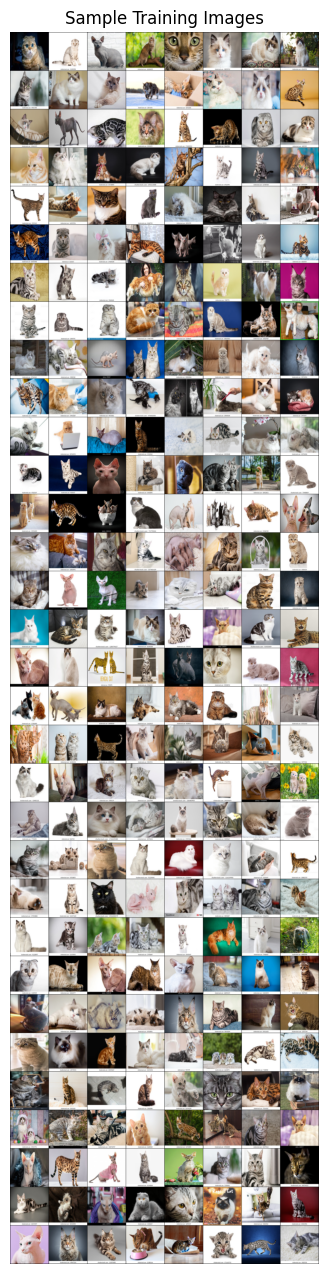

In [65]:
# Plot samples
sample_batch = next(iter(data_loader))
plt.figure(figsize=(20, 16)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

### 2.2: Create the Generator

Now, we need to create a generator for our GAN. You can reuse/modify the code from Lecture 8, or build your own.

In [23]:
class Generator(nn.Module):
    
    def __init__(self, LATENT_SIZE):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            # input dim: [-1, LATENT_SIZE, 1, 1]
            
            nn.ConvTranspose2d(LATENT_SIZE, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 1024, 4, 4]

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 512, 8, 8]

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 256, 16, 16]

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 128, 32, 32]
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 64, 64, 64]

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            
            # output dim: [-1, 3, 128, 128]
            
            nn.Tanh()
            
            # output dim: [-1, 3, 128, 128]
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

### 2.3: Create the Discriminator

Now, we need to create a discriminator for our GAN. You can reuse/modify the code from Lecture 8, or build your own.

In [63]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
        
            # input dim: [-1, 3, 128, 128]
            
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 64, 64, 64]

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 128, 16, 16]

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 256, 8, 8]

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 512, 4, 4]

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            
            # output dim: [-1, 1, 1, 1]

            nn.Flatten(),
            
            # output dim: [-1]

            nn.Sigmoid()
            
            # output dim: [-1]
        )

    def forward(self, input):
        output = self.main(input)
        return output

### 2.4: Initialize Weights

GANs can be quite sensitive to the initial weights assigned to each layer when we instantiate the model. Instantiate your generator and discriminator and then specify their initial weights as follows:

- `Conv2d()` layers: normal distribution with `mean=0.0` and `std=0.02`

- `ConvTranspose2d()` layers: normal distribution with `mean=0.0` and `std=0.02`

- `BatchNorm2d()` layers: normal distribution with `mean=1.0` and `std=0.02` for the weights, zeroes for the biases

- Use `LATENT_SIZE = 100`

In [28]:
LATENT_SIZE = 100

generator = Generator(LATENT_SIZE)
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [29]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
discriminator.apply(weights_init);

### 2.5: Train your GAN

You now have all the ingredients you need now to train a GAN, so give it a go!

You should track the loss of your model as epochs progress and show at least one example of an image output by your trained generator (better yet, record the evolution over time of how your generator is doing, like we did in Lecture 8). **Your results may not be great and that's perfectly okay, you should just show _something_**.

Here are some tips:

- You will likely need to train for at least `NUM_EPOCHS=100` (and maybe more).

- I find that the hardest part about training GANs is that the discriminator "overpowers" the generator, making it hard for the generator to learn how to create realistic images. There are lots of things you can do to try and balance your generator and discriminator, such as: play with the optimizer's hyperparameters, change the architectures of your models, etc.

- Here's a good set of [tips and tricks for training GANs](https://github.com/soumith/ganhacks).

- Once again, GANs are notoriously difficult to train (even more so with smaller data sets like we have here). Don't worry if you're not getting amazing results. This is all about practice.

In [30]:
img_list = []
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1).to(device)

In [ ]:
NUM_EPOCHS = 100

print('Training started:\n')

D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch = [], [], [], []

for epoch in range(NUM_EPOCHS):
    
    D_real_iter, D_fake_iter, loss_dis_iter, loss_gen_iter = [], [], [], []
    
    for real_batch, _ in data_loader:

        # STEP 1: train discriminator
        # ==================================
        # Train with real data
        discriminator.zero_grad()
        
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float).to(device)
        
        output = discriminator(real_batch).view(-1)
        loss_real = criterion(output, real_labels)
        
        # Iteration book-keeping
        D_real_iter.append(output.mean().item())
        
        # Train with fake data
        noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1).to(device)
        
        fake_batch = generator(noise)
        fake_labels = torch.zeros_like(real_labels)
        
        output = discriminator(fake_batch.detach()).view(-1)
        loss_fake = criterion(output, fake_labels)
        
        # Update discriminator weights
        loss_dis = loss_real + loss_fake
        loss_dis.backward()
        optimizerD.step()
        
        # Iteration book-keeping
        loss_dis_iter.append(loss_dis.mean().item())
        D_fake_iter.append(output.mean().item())
        
        # STEP 2: train generator
        # ==================================
        generator.zero_grad()
        output = discriminator(fake_batch).view(-1)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        
        # Book-keeping
        loss_gen_iter.append(loss_gen.mean().item())
        
        # Update generator weights and store loss
        optimizerG.step()
        
    print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})\t",
          f"Loss_G: {mean(loss_gen_iter):.4f}",
          f"Loss_D: {mean(loss_dis_iter):.4f}\t",
          f"D_real: {mean(D_real_iter):.4f}",
          f"D_fake: {mean(D_fake_iter):.4f}")
    
    # Epoch book-keeping
    loss_gen_epoch.append(mean(loss_gen_iter))
    loss_dis_epoch.append(mean(loss_dis_iter))
    D_real_epoch.append(mean(D_real_iter))
    D_fake_epoch.append(mean(D_fake_iter))
    
    # Keeping track of the evolution of a fixed noise latent vector
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        img_list.append(utils.make_grid(fake_images, normalize=True, nrows=10))
        
print("\nTraining ended.")

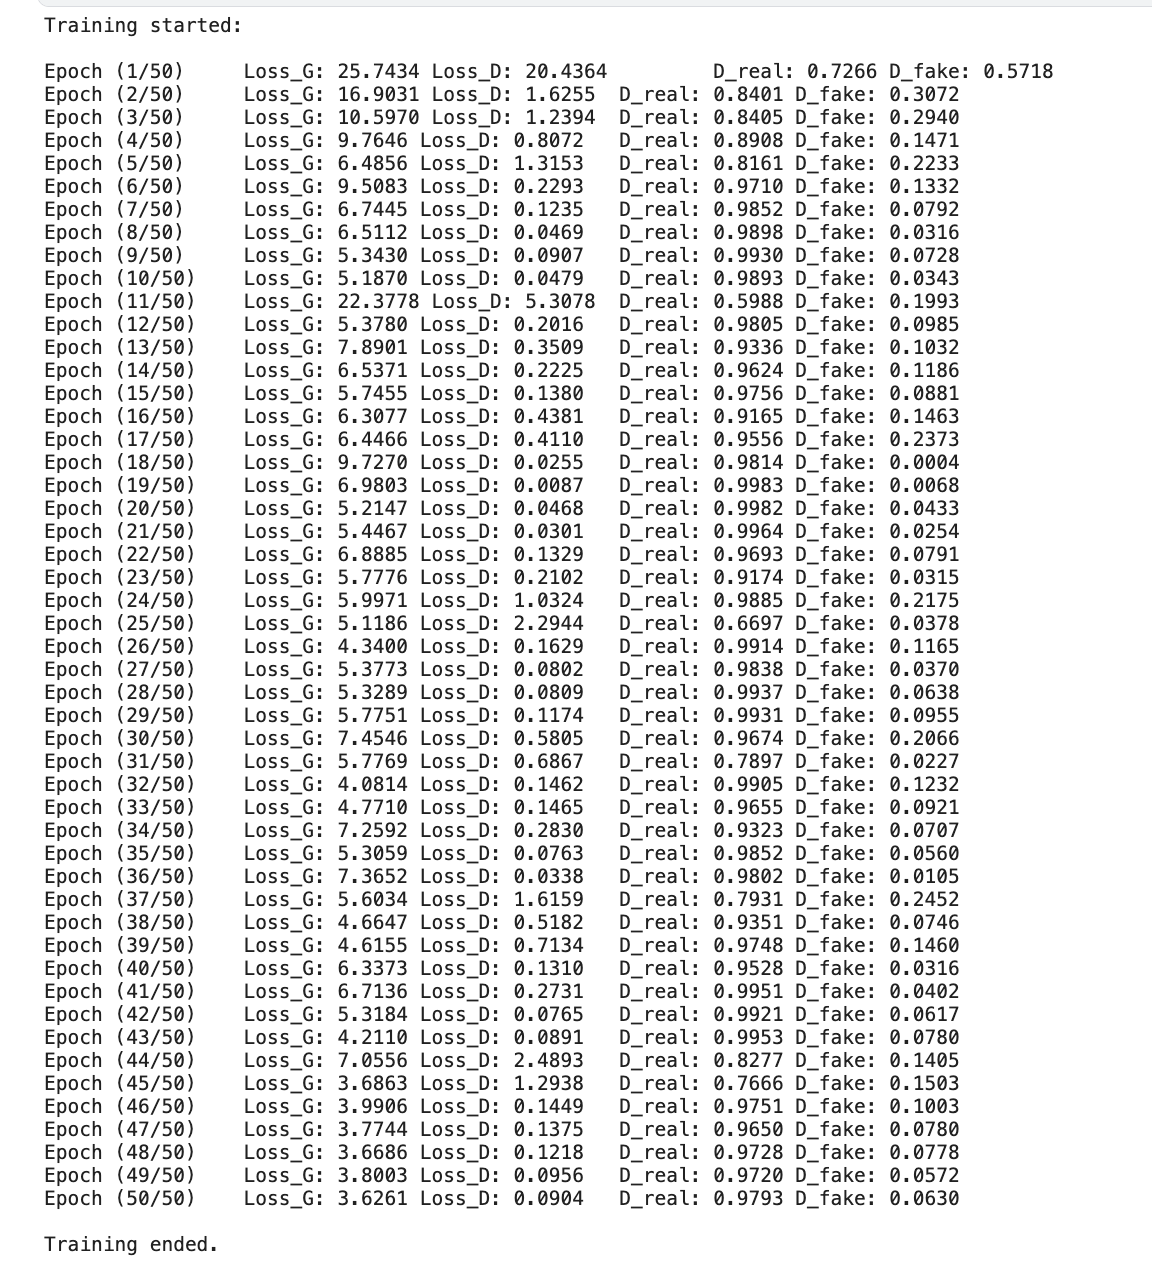

In [67]:
from IPython.display import Image
Image('q2_1.png')

In [ ]:
%%capture

fig = plt.figure(figsize=(10, 10))
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('GAN.gif', writer='imagemagick', fps=2)

In [ ]:
HTML(ani.to_jshtml())

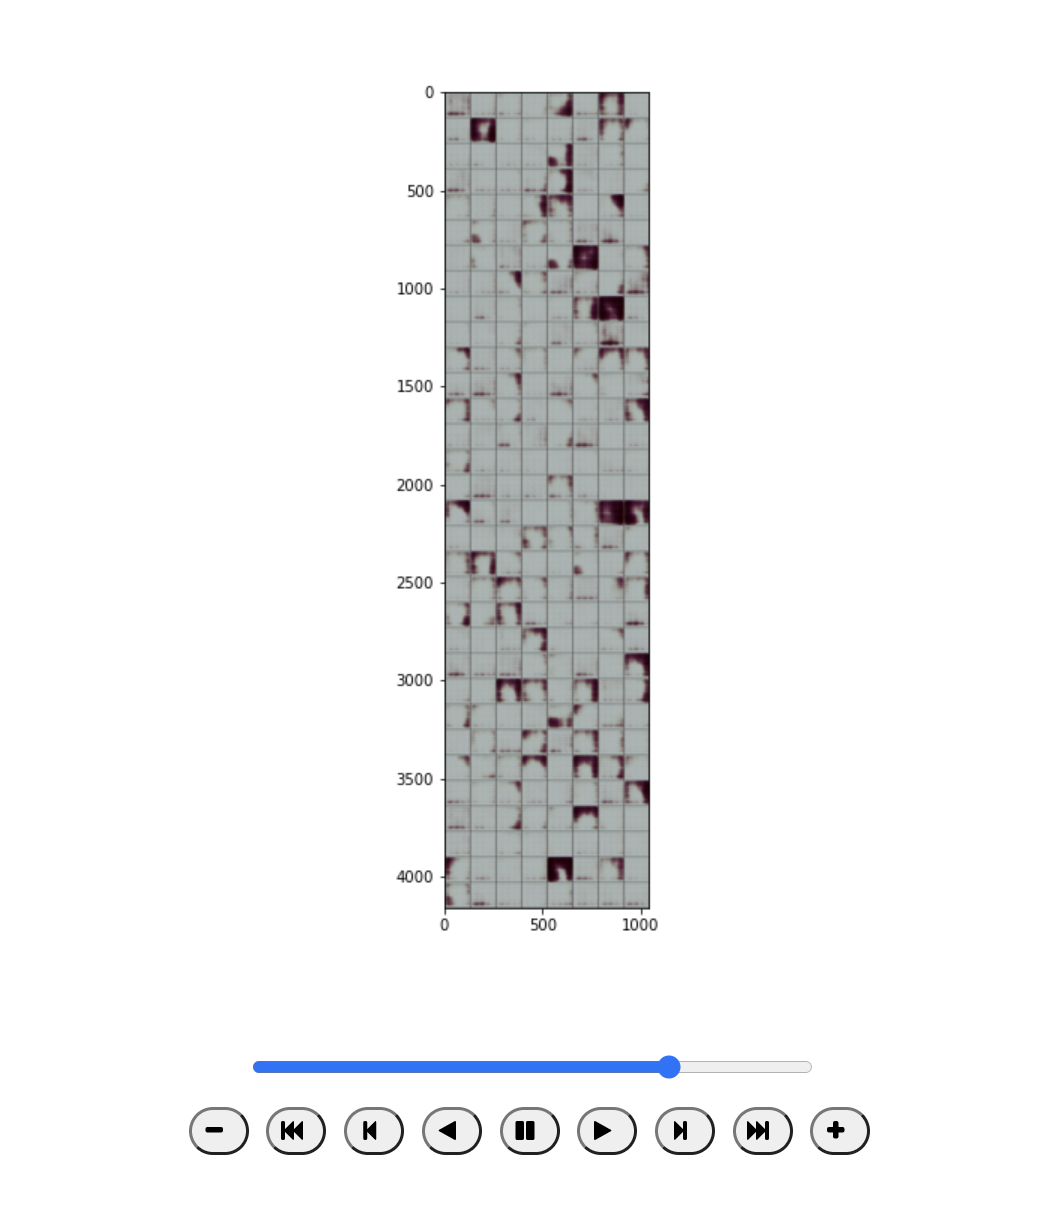

In [68]:

Image('q2_2.png')